In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import matplotlib.pyplot as plt
import warnings
import seaborn as sns

plt.style.use('seaborn')
sns.set_palette('cubehelix')
# plt.style.use('seaborn-colorblind') #alternative
plt.rcParams['figure.figsize'] = [8, 4.5]
plt.rcParams['figure.dpi'] = 300
warnings.simplefilter(action='ignore', category=FutureWarning)

/var/folders/dh/3l29khbn1cq3dss6cwgvbkhw0000gn/T/ipykernel_1477/3377442323.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


## Finding the Efficient Frontier using Monte Carlo simulations

### How to do it...

1. Import the libraries:

In [3]:
import yfinance as yf
import numpy as np
import pandas as pd

2. Set up the parameters:

In [46]:
#vamos a calcular 100.000 posibles combinaciones de Portfolios
N_PORTFOLIOS = 10 ** 5
N_DAYS = 252
# Iberdrola, BBVA, Repsol y Telefonica en el año 2021
#RISKY_ASSETS = ['IBE.MC', 'BBVA.MC', 'REP.MC', 'TEF.MC','MRL.MC','ITX.MC']
RISKY_ASSETS = ['IBE.MC', 'REP.MC','MRL.MC','ITX.MC']
RISKY_ASSETS.sort()
START_DATE = '2021-01-01'
END_DATE = '2021-12-31'

n_assets = len(RISKY_ASSETS)

3. Descargamos sus historicos de Yahoo Finance:

In [47]:
prices_df = yf.download(RISKY_ASSETS, start=START_DATE, 
                        end=END_DATE)
print(f'Downloaded {prices_df.shape[0]} rows of data.')

[*********************100%%**********************]  4 of 4 completed
Downloaded 256 rows of data.


In [48]:
prices_df

Adj Close                                  Close             \
               IBE.MC     ITX.MC    MRL.MC    REP.MC  IBE.MC     ITX.MC   
Date                                                                      
2021-01-04  10.319033  23.776085  6.039270  6.911939  11.905  25.840000   
2021-01-05  10.158679  23.693275  6.159097  7.444020  11.720  25.750000   
2021-01-06  10.600738  24.291357  6.147114  7.546345  12.230  26.400000   
2021-01-07  10.648411  24.134935  6.203033  7.573630  12.285  26.230000   
2021-01-08  10.839104  24.585798  6.155102  7.440609  12.505  26.719999   
...               ...        ...       ...       ...     ...        ...   
2021-12-23   9.072836  26.311621  7.841158  9.102798  10.080  28.150000   
2021-12-27   9.027833  26.377048  7.847867  9.216867  10.030  28.219999   
2021-12-28   9.261854  26.358356  7.950179  9.297593  10.290  28.200001   
2021-12-29   9.257355  26.349007  7.966951  9.194053  10.285  28.190001   
2021-12-30   9.369864  26.666805  8.025656  9.157200  10.410  28.530001   

                             High             ...    Low            Open  \
           MRL.MC  REP.MC  IBE.MC     ITX.MC  ... MRL.MC  REP.MC  IBE.MC   
Date                                          ...                          
2021-01-04  7.560   8.106  11.945  26.430000  ...  7.545   8.082  11.800   
2021-01-05  7.710   8.730  11.910  25.969999  ...  7.505   8.134  11.850   
2021-01-06  7.695   8.850  12.235  26.480000  ...  7.670   8.738  11.840   
2021-01-07  7.765   8.882  12.405  26.570000  ...  7.640   8.580  12.320   
2021-01-08  7.705   8.726  12.570  26.719999  ...  7.680   8.692  12.345   
...           ...     ...     ...        ...  ...    ...     ...     ...   
2021-12-23  9.350  10.374  10.085  28.280001  ...  9.276  10.152   9.938   
2021-12-27  9.358  10.504  10.155  28.280001  ...  9.268  10.274  10.060   
2021-12-28  9.480  10.596  10.320  28.340000  ...  9.322  10.516  10.040   
2021-12-29  9.500  10.478  10.330  28.350000  ...  9.434  10.394  10.330   
2021-12-30  9.570  10.436  10.465  28.580000  ...  9.426  10.408  10.310   

                                        Volume                              
               ITX.MC MRL.MC  REP.MC    IBE.MC   ITX.MC   MRL.MC    REP.MC  
Date                                                                        
2021-01-04  26.430000  7.790   8.328  14213672  8746087  1084339   7901137  
2021-01-05  25.700001  7.575   8.142  22599400  1845863   906461  11674727  
2021-01-06  25.920000  7.715   8.784  16654420  2448623   653545  12401959  
2021-01-07  26.570000  7.780   8.886  19134778  2536892  1571183  17011938  
2021-01-08  26.500000  7.800   8.980  13474949  2326181   694566  11807348  
...               ...    ...     ...       ...      ...      ...       ...  
2021-12-23  28.080000  9.276  10.178   6618825  1566972   555661   7561362  
2021-12-27  28.000000  9.268  10.296   5529024   949069   781133   4732857  
2021-12-28  28.230000  9.368  10.530   7228174   888557   601762   7363456  
2021-12-29  28.280001  9.480  10.554   5413653  1313427   655711   3405221  
2021-12-30  28.170000  9.474  10.432   9249684  1459057   610224   6822415  

[256 rows x 24 columns]

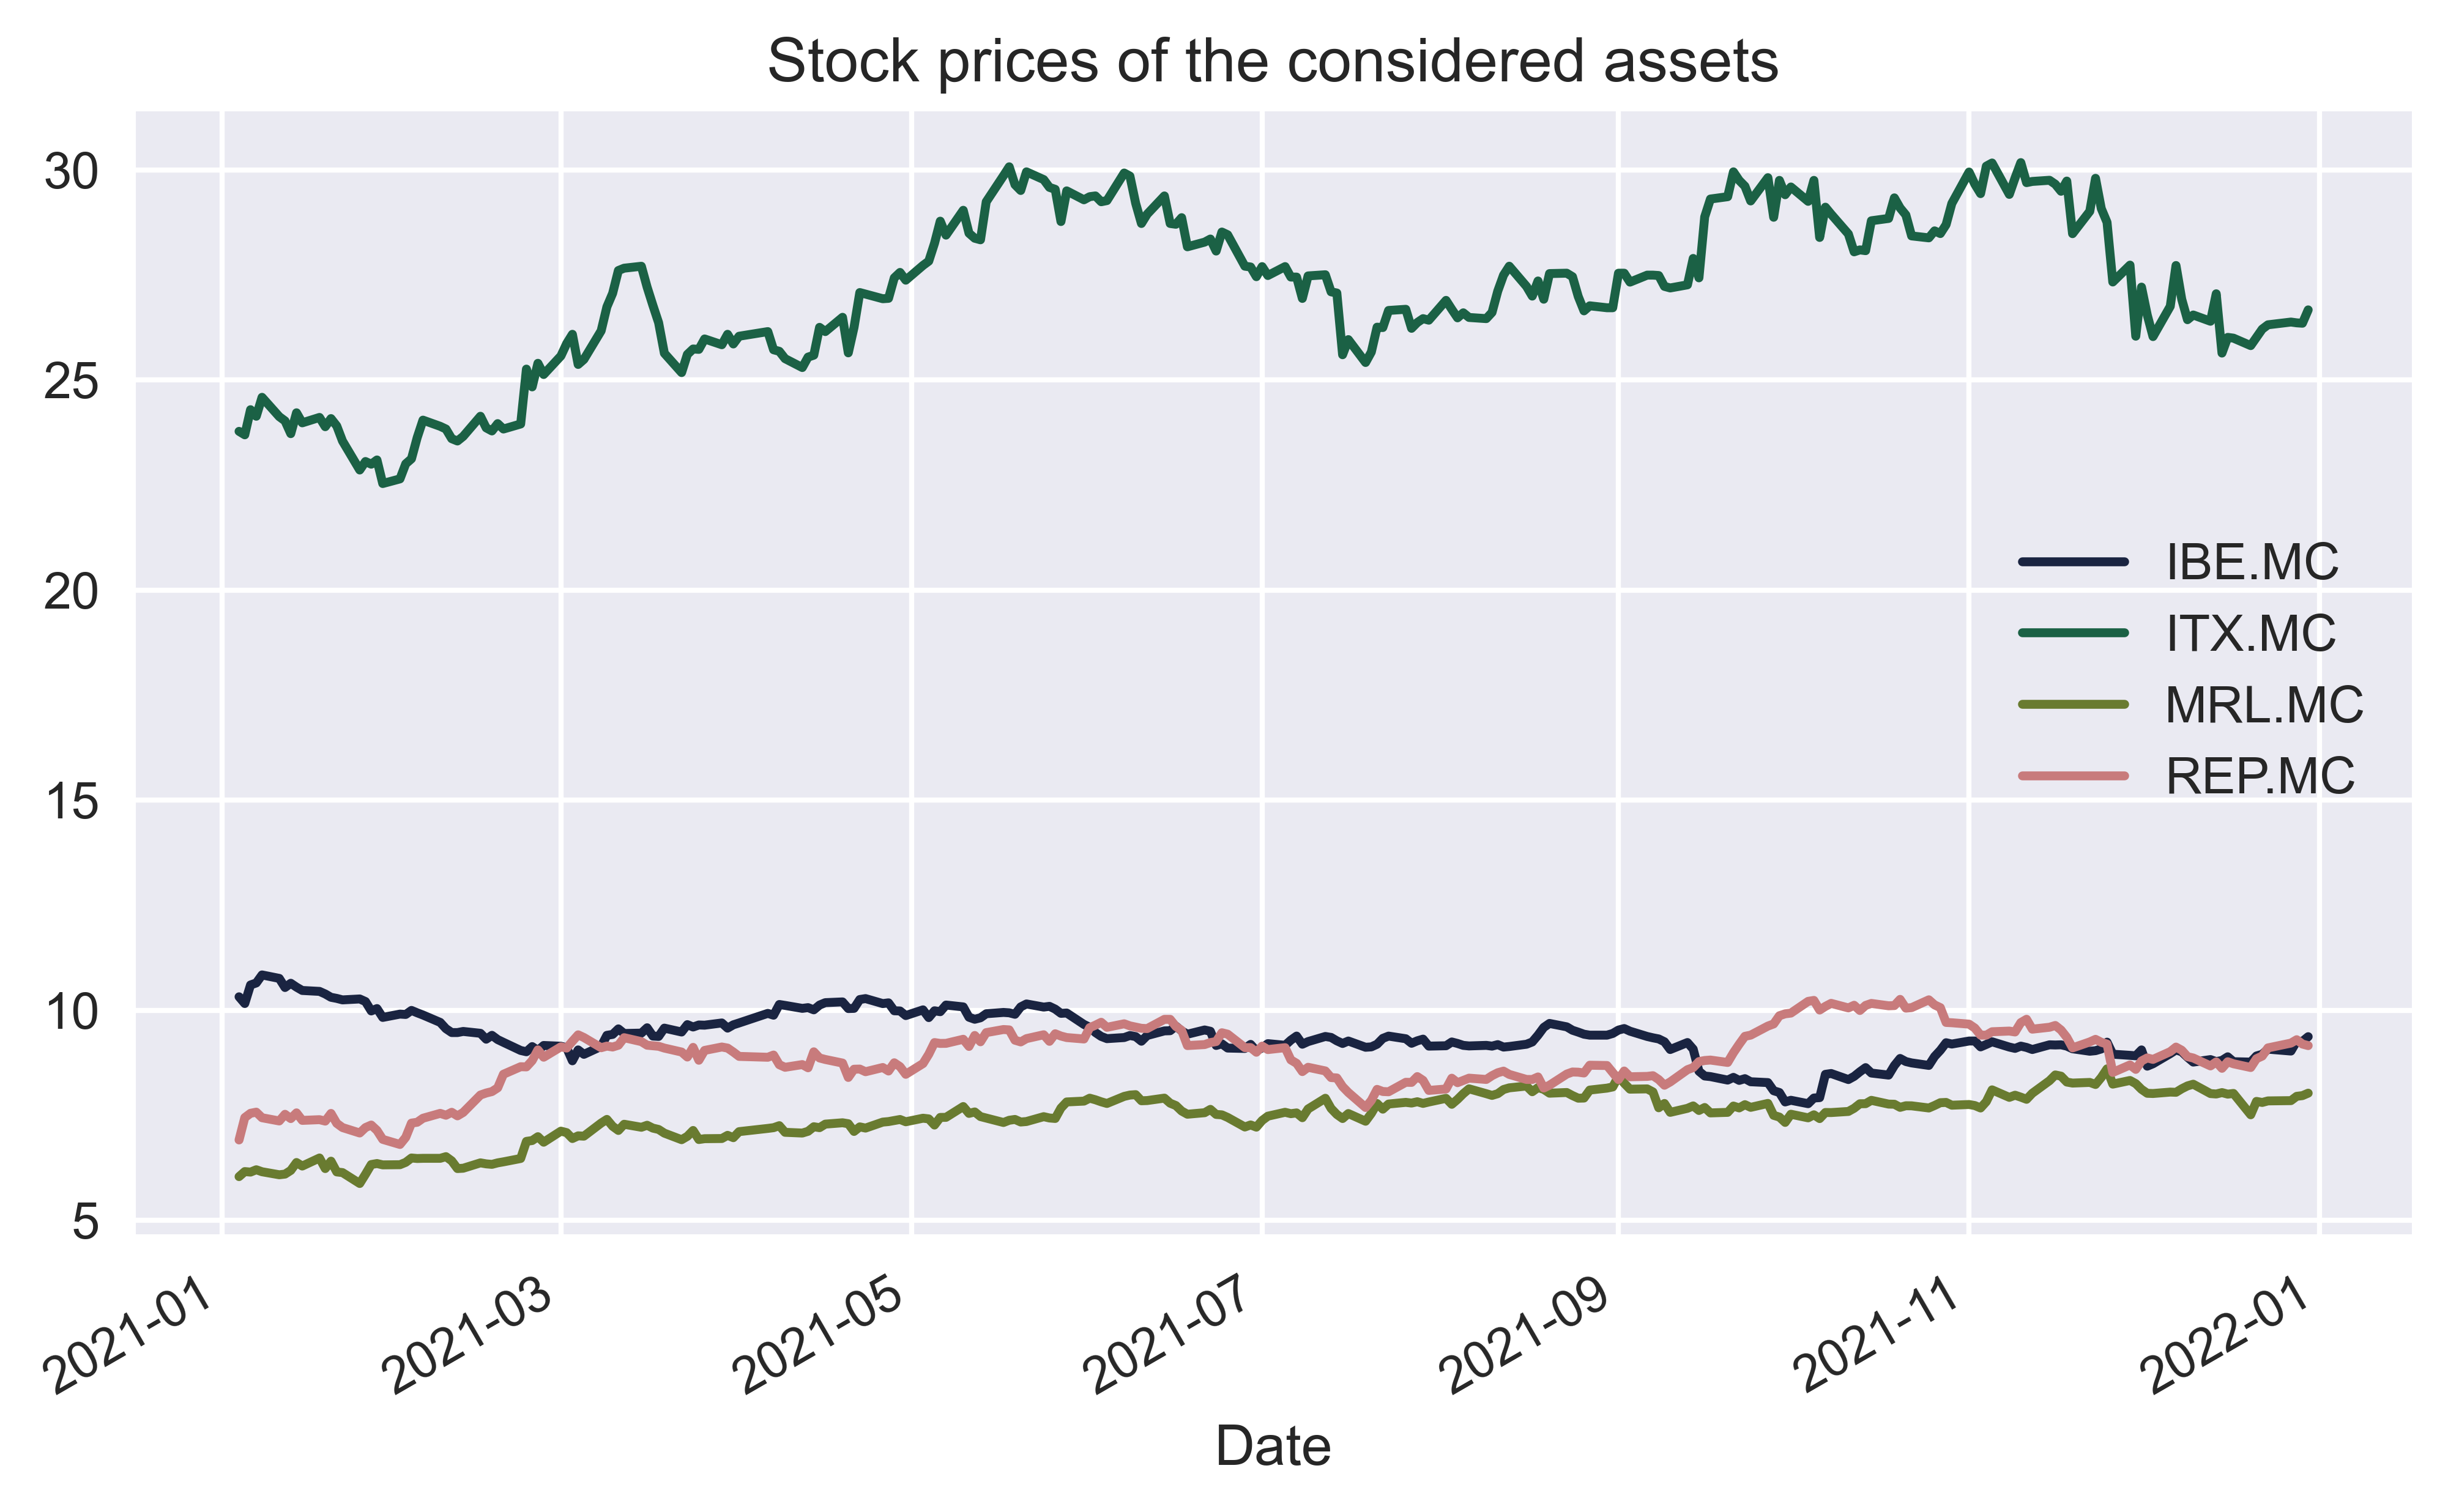

In [49]:
#visualizamos sus cotizaciones
prices_df['Adj Close'].plot(title='Stock prices of the considered assets');

4. Calculamos las medias anualizadas y la matriz de covarianza:

In [7]:
returns_df = prices_df['Adj Close'].pct_change().dropna()

avg_returns = returns_df.mean() * N_DAYS
cov_mat = returns_df.cov() * N_DAYS

In [23]:
cov_mat

IBE.MC    ITX.MC    MRL.MC    REP.MC
IBE.MC  0.047315  0.016763  0.012254  0.000873
ITX.MC  0.016763  0.073248  0.026804  0.030722
MRL.MC  0.012254  0.026804  0.072084  0.023835
REP.MC  0.000873  0.030722  0.023835  0.083515

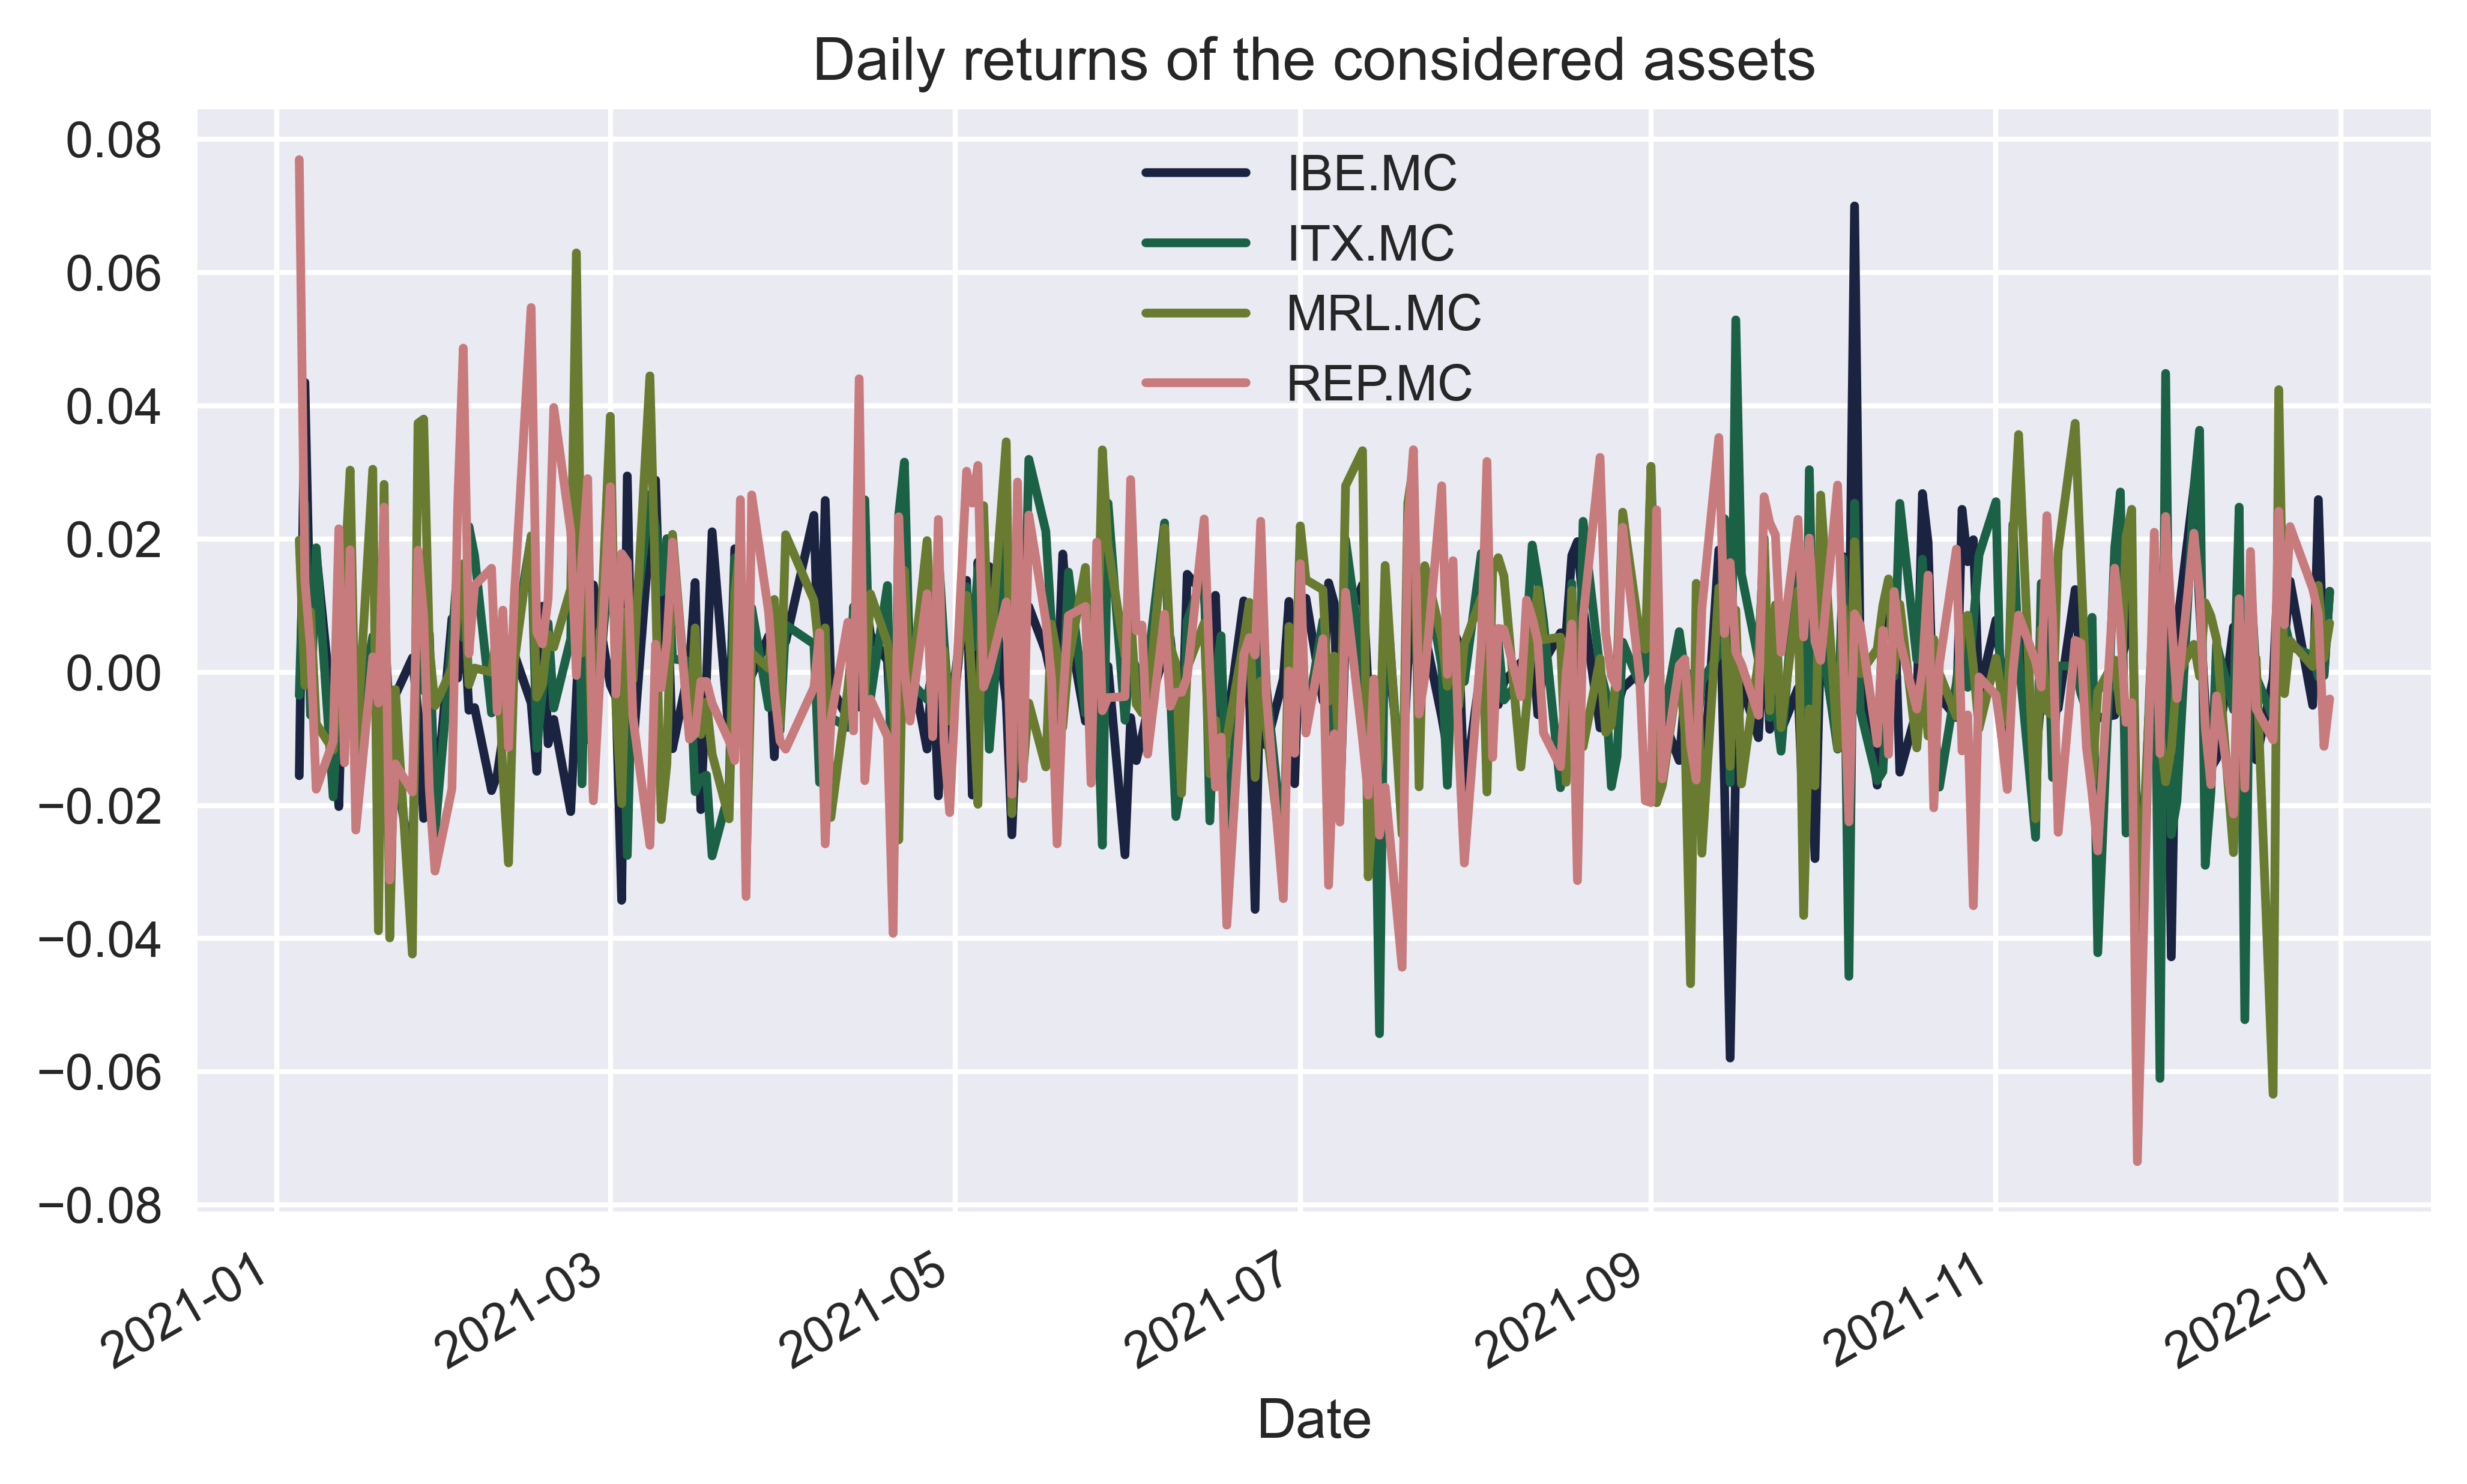

In [50]:
returns_df.plot(title='Daily returns of the considered assets');

5. Simulamos los pesos de los portfolios:

In [28]:
np.random.seed(42)
weights = np.random.random(size=(N_PORTFOLIOS, n_assets))
weights /=  np.sum(weights, axis=1)[:, np.newaxis]

In [30]:
np.random.seed(42)
weights = np.random.random(size=(N_PORTFOLIOS, n_assets))

In [31]:
weights

array([[0.37454012, 0.95071431, 0.73199394, 0.59865848],
       [0.15601864, 0.15599452, 0.05808361, 0.86617615],
       [0.60111501, 0.70807258, 0.02058449, 0.96990985],
       ...,
       [0.59434465, 0.83958621, 0.83204045, 0.12633307],
       [0.68086432, 0.39162364, 0.74418775, 0.75014828],
       [0.27252781, 0.5755887 , 0.89333979, 0.50242265]])

In [32]:
weights /=  np.sum(weights, axis=1)[:, np.newaxis]

In [33]:
weights

array([[0.14102156, 0.35796222, 0.27560979, 0.22540643],
       [0.12620081, 0.1261813 , 0.04698284, 0.70063506],
       [0.2613905 , 0.30790022, 0.00895102, 0.42175826],
       ...,
       [0.24844023, 0.35095292, 0.34779874, 0.05280811],
       [0.26525555, 0.15257129, 0.28992551, 0.29224765],
       [0.12145388, 0.25651504, 0.39812299, 0.22390809]])

6. Calculamos las metricas de los portfolios:

In [11]:
#formula del calculo de returns de un portfolio
portf_rtns = np.dot(weights, avg_returns)

#Volatilidad
# Este for es equivalente :
# np.diag(np.sqrt(np.dot(weights, np.dot(cov_mat, weights.T))))

portf_vol = []
#para matrices tan grandes es más efectivo un loop que np.diag()
for i in range(0, len(weights)):
    portf_vol.append(np.sqrt(np.dot(weights[i].T, 
                                    np.dot(cov_mat, weights[i]))))
portf_vol = np.array(portf_vol)
#Sharp Ratio, asumimos risk free rate 0%
portf_sharpe_ratio = portf_rtns / portf_vol

In [51]:
portf_sharpe_ratio

array([1.07064428, 1.09890017, 0.86647974, ..., 0.8717827 , 1.07880034,
       1.18852143])

In [52]:
portf_vol

array([0.18961566, 0.2263371 , 0.190508  , ..., 0.18578543, 0.17536669,
       0.19146929])

In [12]:
len(portf_vol)

100000

7. Juntamos todos los datos en un DataFrame:

In [13]:
portf_results_df = pd.DataFrame({'returns': portf_rtns,
                                 'volatility': portf_vol,
                                 'sharpe_ratio': portf_sharpe_ratio})

In [53]:
portf_results_df

returns  volatility  sharpe_ratio
0      0.203011    0.189616      1.070644
1      0.248722    0.226337      1.098900
2      0.165071    0.190508      0.866480
3      0.062664    0.169675      0.369318
4      0.184851    0.183753      1.005978
...         ...         ...           ...
99995  0.207784    0.207832      0.999770
99996  0.199645    0.187769      1.063247
99997  0.161965    0.185785      0.871783
99998  0.189186    0.175367      1.078800
99999  0.227565    0.191469      1.188521

[100000 rows x 3 columns]

8. Locate the points creating the Efficient Frontier:

In [14]:
N_POINTS = 100
portf_vol_ef = []
indices_to_skip = []

#100 ptos para pintar el efficient frontier
portf_rtns_ef = np.linspace(portf_results_df.returns.min(), 
                            portf_results_df.returns.max(), 
                            N_POINTS)
#redondeamos con 2 decimales
portf_rtns_ef = np.round(portf_rtns_ef, 2)    
portf_rtns = np.round(portf_rtns, 2)

for point_index in range(N_POINTS):
    if portf_rtns_ef[point_index] not in portf_rtns:
        indices_to_skip.append(point_index)
        continue
        #devuelve los indices donde son iguales
    matched_ind = np.where(portf_rtns == portf_rtns_ef[point_index])
    #nos quedamos con el expected return con la minima Volatilidad
    portf_vol_ef.append(np.min(portf_vol[matched_ind]))
    
portf_rtns_ef = np.delete(portf_rtns_ef, indices_to_skip)

9. Plot the Efficient Frontier:

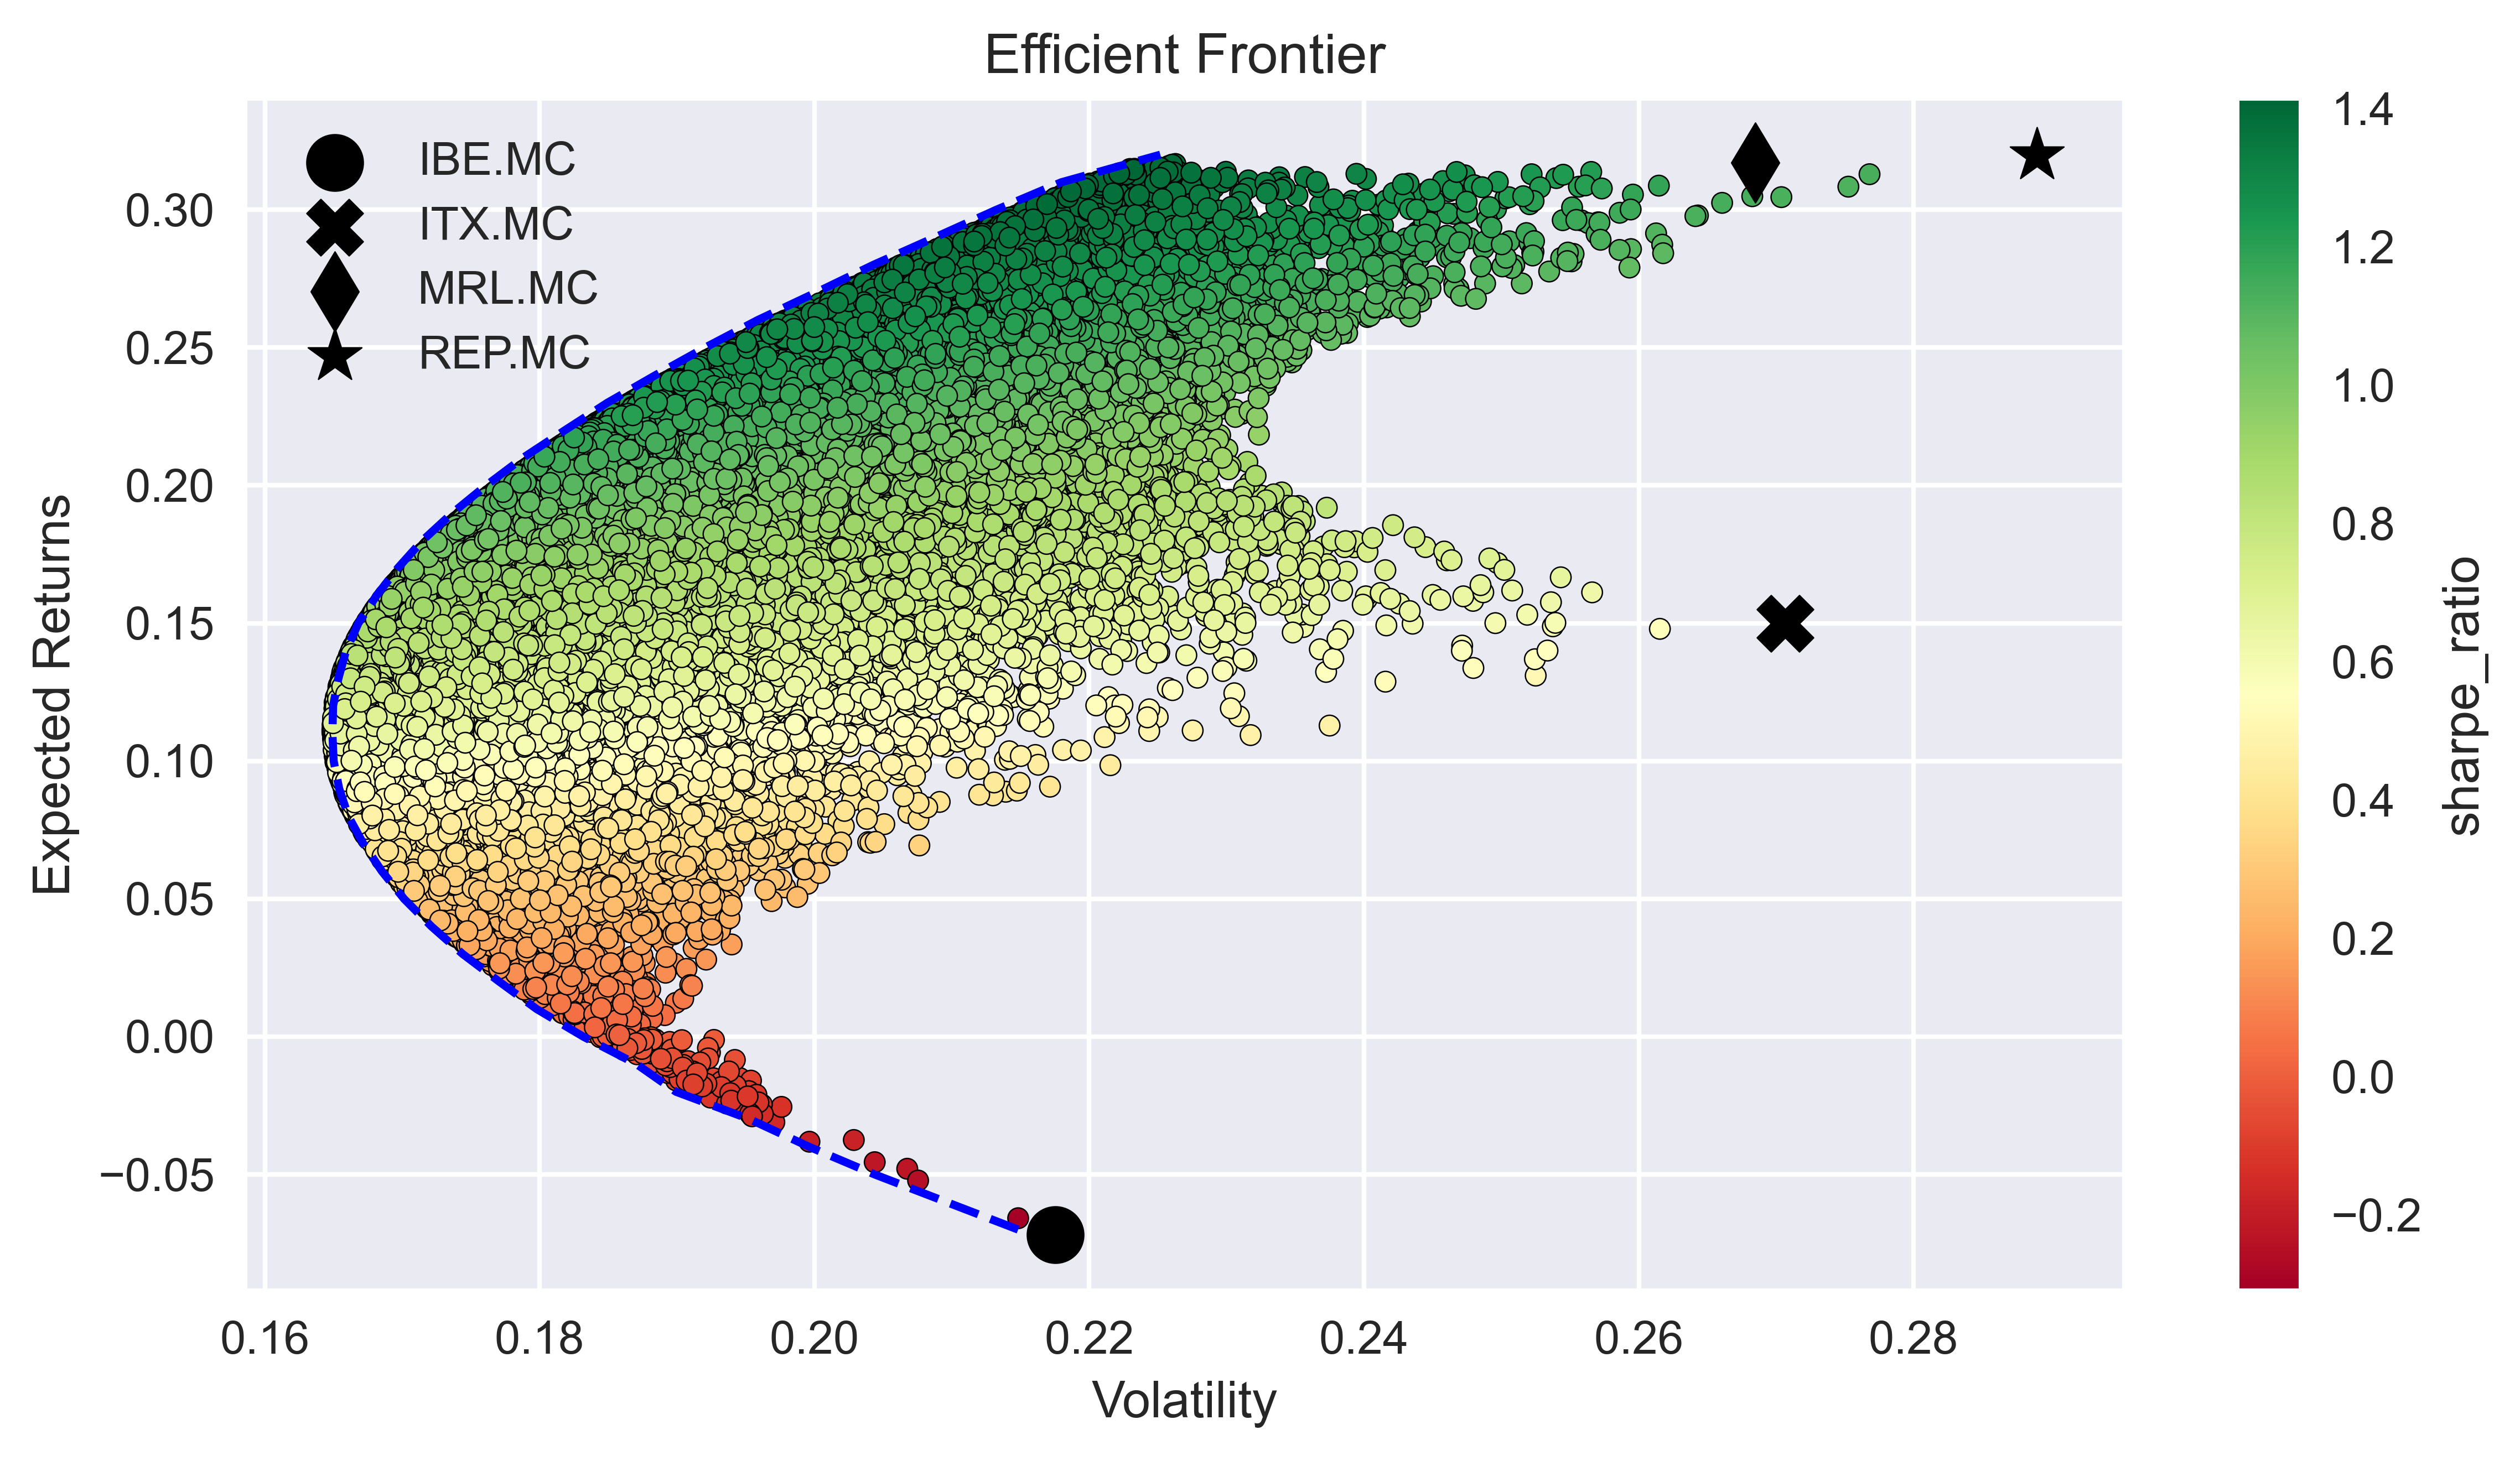

In [42]:
#MARKS = ['o', 'X', 'd', '*','s','P']
MARKS = ['o', 'X', 'd', '*']

fig, ax = plt.subplots()
#scatterplot de los 100.000 portfolios
portf_results_df.plot(kind='scatter', x='volatility', 
                      y='returns', c='sharpe_ratio',
                      cmap='RdYlGn', edgecolors='black',
                      ax=ax
                      )
#etiquetas de los ejes
ax.set(xlabel='Volatility', 
       ylabel='Expected Returns', 
       title='Efficient Frontier')
#Pintamos la linea del EF de azul
ax.plot(portf_vol_ef, portf_rtns_ef, 'b--')
#La posicion de los Assets
for asset_index in range(n_assets):
    ax.scatter(x=np.sqrt(cov_mat.iloc[asset_index, asset_index]), 
                y=avg_returns[asset_index], 
                marker=MARKS[asset_index], 
                s=150, 
                color='black',
                label=RISKY_ASSETS[asset_index])
ax.legend()

plt.tight_layout()
plt.show()

### Localicemos los portfolios con el mayor Sharp Ratio y Mínima Volatilidad

Valores de Sharp Ratio Max y Minima Volatilidad

In [16]:
max_sharpe_ind = np.argmax(portf_results_df.sharpe_ratio)
max_sharpe_portf = portf_results_df.loc[max_sharpe_ind]

min_vol_ind = np.argmin(portf_results_df.volatility)
min_vol_portf = portf_results_df.loc[min_vol_ind]

Vemos como se constituyen los portfolios anteriores

In [17]:
print('Maximum Sharpe Ratio portfolio ----')
print('Performance')
for index, value in max_sharpe_portf.items():
    print(f'{index}: {100 * value:.2f}% ', end="", flush=True)
print('\nWeights')
for x, y in zip(RISKY_ASSETS, weights[np.argmax(portf_results_df.sharpe_ratio)]):
    print(f'{x}: {100*y:.2f}% ', end="", flush=True)

Maximum Sharpe Ratio portfolio ----
Performance
returns: 31.48% volatility: 22.30% sharpe_ratio: 141.19% 
Weights
IBE.MC: 0.45% ITX.MC: 0.98% MRL.MC: 55.30% REP.MC: 43.27% 

In [18]:
print('Minimum Volatility portfolio ----')
print('Performance')
for index, value in min_vol_portf.items():
    print(f'{index}: {100 * value:.2f}% ', end="", flush=True)
print('\nWeights')
for x, y in zip(RISKY_ASSETS, weights[np.argmin(portf_results_df.volatility)]):
    print(f'{x}: {100*y:.2f}% ', end="", flush=True)

Minimum Volatility portfolio ----
Performance
returns: 11.05% volatility: 16.49% sharpe_ratio: 67.01% 
Weights
IBE.MC: 49.15% ITX.MC: 9.58% MRL.MC: 17.98% REP.MC: 23.28% 

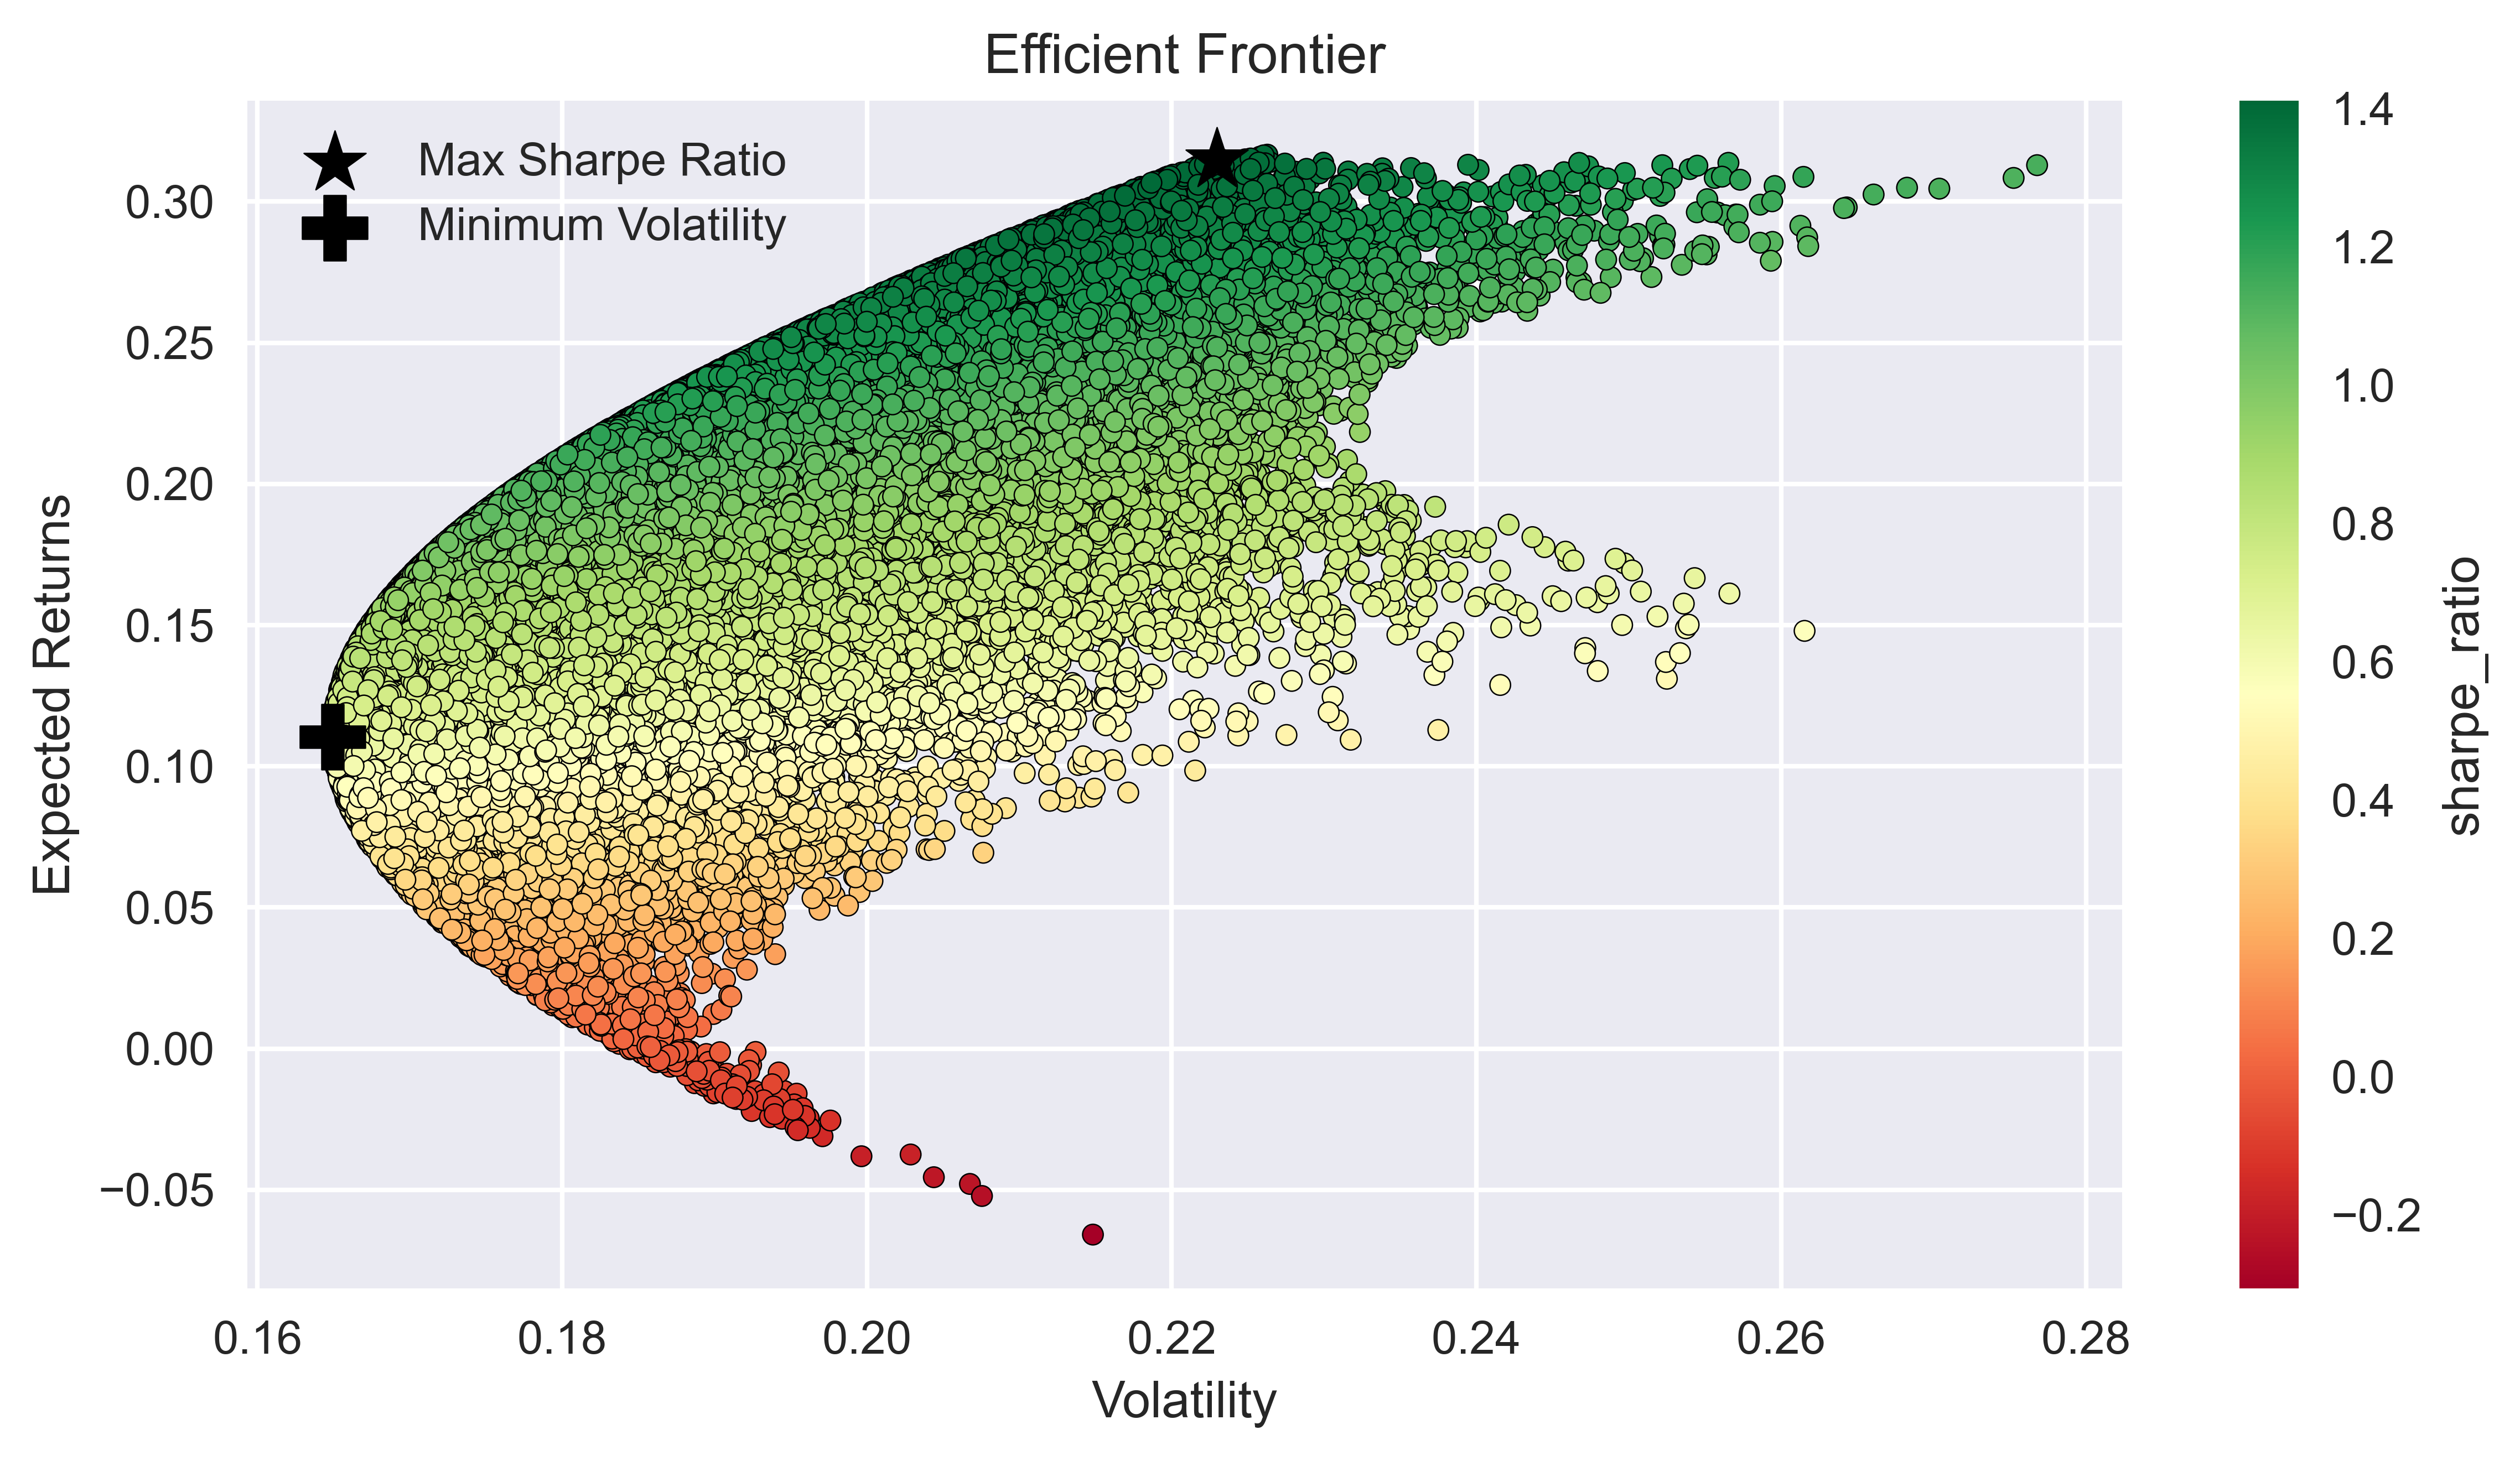

In [19]:
fig, ax = plt.subplots()
portf_results_df.plot(kind='scatter', x='volatility', 
                      y='returns', c='sharpe_ratio',
                      cmap='RdYlGn', edgecolors='black', 
                      ax=ax)
ax.scatter(x=max_sharpe_portf.volatility, 
           y=max_sharpe_portf.returns, 
           c='black', marker='*', 
           s=200, label='Max Sharpe Ratio')
ax.scatter(x=min_vol_portf.volatility, 
           y=min_vol_portf.returns, 
           c='black', marker='P', 
           s=200, label='Minimum Volatility')
ax.set(xlabel='Volatility', ylabel='Expected Returns', 
       title='Efficient Frontier')
ax.legend()

plt.tight_layout()
#plt.savefig('images/EF_Maximos.png #Por Si lo quieres guardar para informes
plt.show()